In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras
print('tf    version: {}'.format(tf.__version__) )
print('keras version: {}'.format(keras.__version__) )
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

tf    version: 2.2.0-dev20200218
keras version: 2.2.4-tf
matplotlib 3.0.3
numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
tensorflow 2.2.0-dev20200218
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()


In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)

In [4]:
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [8]:
class CustomizedDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(CustomizedDenseLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        # x*w +b. input_shape:[None, a] output_shape:[None,b]
        self.kernel = self.add_weight(
                    name='kernel', 
                    shape=(input_shape[1], self.units),
                    initializer ='uniform',
                    trainable=True
                    )
        self.bias = self.add_weight(
            name='bias', 
            shape=(self.units, ), 
            initializer ='zeros', 
            trainable=True
        )
        
        super(CustomizedDenseLayer, self).build(input_shape)
        
    def call(self, x):
        return self.activation(x @ self.kernel + self.bias)

    
    

model = keras.models.Sequential([
    CustomizedDenseLayer(30, activation='relu', 
                      input_shape=x_train.shape[1:]),
    CustomizedDenseLayer(1), 
    
])
model.summary()
model.compile(loss='mean_squared_error', 
             optimizer = keras.optimizers.SGD(0.001),
              metrics=['mean_squared_error']
             )

callbacks = [keras.callbacks.EarlyStopping(patience=5, 
                                           min_delta=1e-4)
]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
customized_dense_layer_4 (Cu (None, 30)                270       
_________________________________________________________________
customized_dense_layer_5 (Cu (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history = model.fit(x_train_scaled, y_train, 
                    validation_data= (x_valid_scaled, y_valid), 
                   epochs = 30,
                    callbacks= callbacks
                   )

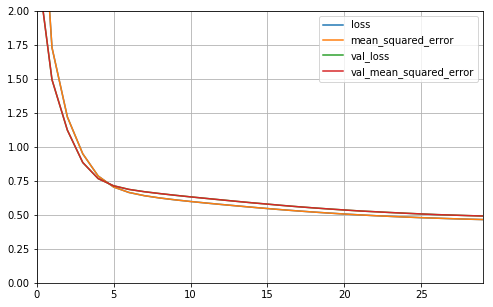

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2)
    plt.show()
    
    
plot_learning_curves(history)

In [16]:
model.evaluate(x_test_scaled, y_test)

5160/5160 [==============================] - 0s 26us/sample - loss: 0.3915


0.3914905628492666

# tf.function and autograph. 

In [16]:
def scaled_elu(z, scale=1.0, alpha=1.0):
    is_positive = tf.greater_equal(z, 0.0)
    return scale * tf.where(is_positive, z, alpha * tf.nn.elu(z))
    
print(scaled_elu(tf.constant(-3.)))
print(scaled_elu(tf.constant([-3., -2.5])))

scaled_elu_tf = tf.function(scaled_elu)
print(scaled_elu_tf(tf.constant(-3.)))

tf.Tensor(-0.95021296, shape=(), dtype=float32)
tf.Tensor([-0.95021296 -0.917915  ], shape=(2,), dtype=float32)
tf.Tensor(-0.95021296, shape=(), dtype=float32)


In [18]:
%timeit scaled_elu(tf.random.normal((2000, 1000)))
%timeit scaled_elu_tf(tf.random.normal((2000, 1000)))

20.9 ms ± 60.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
15.8 ms ± 55.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
def converge_to_2(n_iters):
    total = tf.constant(0.)
    increment = tf.constant(1.)
    for _ in range(n_iters):
        total += increment
        increment /= 2.0
    return total

print(converge_to_2(20))

tf.Tensor(1.9999981, shape=(), dtype=float32)


In [20]:
def display_tf_code(func):
    code = tf.autograph.to_code(func)
    from IPython.display import display, Markdown
    display(Markdown('```python\n {} ```'.format(code)))
    
display_tf_code(converge_to_2)

```python
 def tf__converge_to_2(n_iters):
    do_return = False
    retval_ = ag__.UndefinedReturnValue()
    with ag__.FunctionScope('converge_to_2', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        total = ag__.converted_call(tf.constant, (0.0,), None, fscope)
        increment = ag__.converted_call(tf.constant, (1.0,), None, fscope)

        def get_state():
            return (total, increment)

        def set_state(loop_vars):
            nonlocal total, increment
            (total, increment) = loop_vars

        def loop_body(itr):
            nonlocal total, increment
            _ = itr
            total += increment
            increment /= 2.0
        ag__.for_stmt(ag__.converted_call(range, (n_iters,), None, fscope), None, loop_body, get_state, set_state, ('total', 'increment'), {})
        do_return = True
        retval_ = fscope.mark_return_value(total)
    (do_return,)
    return ag__.retval(retval_)
 ```

# 求导 微分求法

In [50]:
def f(x):
    return 3. * x **2 + 2. *x -1

print(f(2))

15.0


In [51]:
def approximate_derivative(f, x, eps=1e-3):
    return (f(x+eps)-f(x-eps))/(2. * eps)

print(approximate_derivative(f, 1.))
    

7.999999999999119


In [52]:
def g(x1, x2):
    return (x1 +5) * (x2 **2)
    
def approximate_gradient(g, x1, x2, eps=1e-3):
    dg_x1 = approximae_derivative(lambda x: g(x, x2), x1, eps)
    dg_x2 = approximae_derivative(lambda x: g(x1, x), x2, eps)
    return dg_x1, dg_x2

print(approximate_gradient(g, 2., 3. ))

(8.999999999993236, 41.999999999994486)


# 求导 梯度下降

In [53]:
x1 = tf.Variable(2.0)
x2 = tf.Variable(3.0)
with tf.GradientTape() as tape:
    z = g(x1, x2)

dz_x1 = tape.gradient(z, x1)
print(dz_x1)

try:
    dz_x2 = tape.gradient(z, x2)
except RuntimeError as ex:
    print(ex)

tf.Tensor(9.0, shape=(), dtype=float32)
GradientTape.gradient can only be called once on non-persistent tapes.


In [54]:
x1 = tf.Variable(2.0)
x2 = tf.Variable(3.0)
with tf.GradientTape(persistent = True) as tape:
    z = g(x1, x2)

dz_x1 = tape.gradient(z, x1)
dz_x2 = tape.gradient(z, x2)
print(dz_x1, dz_x2)

try:
    dz_x2 = tape.gradient(z, x2)
except RuntimeError as ex:
    print(ex)

tf.Tensor(9.0, shape=(), dtype=float32) tf.Tensor(42.0, shape=(), dtype=float32)


In [55]:
x = tf.Variable(5.0)
with tf.GradientTape() as tape:
    z1 = 3 * x
    z2 = x ** 2
tape.gradient([z1, z2], x)

<tf.Tensor: shape=(), dtype=float32, numpy=13.0>

# 梯度下降

In [56]:
learning_rate = 0.1
x = tf.Variable(0.0)

optimizer = keras.optimizers.SGD(lr=learning_rate)


for _ in range(100):
    with tf.GradientTape() as tape:
        z = f(x)
    dz_dx = tape.gradient(z, x)
    optimizer.apply_gradients([(dz_dx, x)])

print(x)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.3333333>
